In [1]:
import matplotlib.pyplot as plt
import numpy as np

import jax
import jax.numpy as jnp
import jax.random as random

import numpyro
import numpyro.distributions as dist
import numpyro.optim as optim
from numpyro.infer import SVI, Trace_ELBO
from numpyro.infer.autoguide import AutoLaplaceApproximation, AutoNormal

from jax import random, grad
from scipy.optimize import minimize

plt.style.use("seaborn-v0_8")
import q3

rng_key, rng_key_ = random.split(random.PRNGKey(0))
# Note here inputs are description_legths and playback_speed have ranges 0-100.
# data = q3.simulate(50, 50)

In [2]:
def get_data(rng_key, num_samples=100):
    
    rng_key, key_train, key_test = jax.random.split(rng_key, 3)
    
    X_train = jax.random.randint(key_train, (num_samples, 2), 0, 100)
    X_test = jax.random.randint(key_test, (num_samples, 2), 0, 100)
    
    Y_train = [q3.simulate(x[0], x[1]) for x in X_train]
    Y_test  = [q3.simulate(x[0], x[1]) for x in X_test]
    
    Y_train = jnp.array([[y] for y in Y_train])
    Y_test = jnp.array([[y] for y in Y_test])
    
    return X_train, Y_train, X_test, Y_test

def sort_vectors(X, Y, axis=0):
    # Get the indices that would sort X by the first column.
    sorted_indices = np.argsort(X[:, axis])
    # Use the sorted indices to reorder X and Y.
    X_sorted = X[sorted_indices]
    Y_sorted = Y[sorted_indices]
    return X_sorted, Y_sorted, sorted_indices

### Kernel functions are defined here

In [3]:
# squared exponential kernel with diagonal noise term
def exponential_kernel(X1, X2, var, length, noise, include_noise=True):
    
    # diff shape: (n_samples1, n_samples2, n_features)
    diff = X1[:, None, :] - X2[None, :, :]
    delta_sq = jnp.sum((diff / length) ** 2, axis=-1)
    
    k = var * jnp.exp(-0.5 * delta_sq)
    
    if include_noise:
        # Add a small constant to avoid exact zeros in the noise term
        noise = noise + 1.0e-6
        if X1.shape[0] == X2.shape[0]: # and jnp.allclose(X1, X2)
            k += noise * jnp.eye(X1.shape[0])
            
    return k

### Expectation Improvement

In [4]:
def expected_improvement(mu, s2, f_best):
    # Convert variance to standard deviation.
    sigma = jnp.sqrt(s2)
    
    # Improvement relative to the best observation.
    improvement = mu - f_best
    
    # Compute Z safely by handling the sigma==0 case.
    Z = jnp.where(sigma > 0, improvement / sigma, 0.0)
    
    # Standard expected improvement formula.
    ei = improvement * jax.scipy.stats.norm.cdf(Z) + sigma * jax.scipy.stats.norm.pdf(Z)
    
    # For sigma equal to zero, define EI as max(0, improvement).
    ei_mean = jnp.where(sigma == 0, jnp.maximum(0.0, improvement), ei)

    # Average EI across all observations.
    # ei_mean = jnp.mean(ei, axis=0)

    return ei_mean

### Gaussian Process model

In [5]:
def model(X, Y, kernel=exponential_kernel):
    
    # set uninformative log-normal priors on our three kernel hyperparameters
    var = numpyro.sample("kernel_var", dist.LogNormal(0.0, 10.0))
    noise = numpyro.sample("kernel_noise", dist.LogNormal(0.0, 10.0))
    length = numpyro.sample("kernel_length", dist.LogNormal(0.0, 10.0))

    # compute kernel
    k = kernel(X, X, var, length, noise)
    
    # sample Y according to the standard gaussian process formula
    numpyro.sample("Y", dist.MultivariateNormal(loc=jnp.zeros(X.shape[0]), covariance_matrix=k), obs=Y)

def predict(rng_key, X, Y, X_test, var, length, noise, kernel=exponential_kernel):
    # compute kernels between train and test data, etc.
    k_pp = kernel(X_test, X_test, var, length, noise, include_noise=True)
    k_pX = kernel(X_test, X, var, length, noise, include_noise=False)
    k_XX = kernel(X, X, var, length, noise, include_noise=True)

    K_xx_inv = jnp.linalg.inv(k_XX)
    K = k_pp - jnp.matmul(k_pX, jnp.matmul(K_xx_inv, jnp.transpose(k_pX)))

    var_pred = jnp.clip(jnp.diag(K), a_min=0.0)
    sigma = jnp.sqrt(var_pred)

    # compute mean
    mean = jnp.matmul(k_pX, jnp.matmul(K_xx_inv, Y)).squeeze()

    noise_sample = sigma * jax.random.normal(rng_key, shape=sigma.shape)
    sample = mean + noise_sample

    # Return the mean, the predictive variance (for EI), and a sample.
    return mean, var_pred, sample


In [6]:
NUM_CANDIDATE_SAMPLES = 100
NUM_ITERATIONS = 20
LEARNING_RATE = 1e-2

### Training Loop for GP using BO

In [7]:
# Initial Dataset 
X, Y, _, _ = get_data(rng_key, num_samples=20)


 Iteration 0


100%|██████████| 1000/1000 [00:01<00:00, 789.17it/s, init loss: 382.4525, avg. loss [951-1000]: -1861.3823]


Best observed value so far: 0.8163394331932068
Next candidate selected: [58 69]
Simulation output at candidate: 0.2462326902892682

 Iteration 1


100%|██████████| 1000/1000 [00:01<00:00, 905.64it/s, init loss: 44.8841, avg. loss [951-1000]: -0.5775]


Best observed value so far: 0.8163394331932068
Next candidate selected: [34 94]
Simulation output at candidate: 0.47864713572973927

 Iteration 2


100%|██████████| 1000/1000 [00:01<00:00, 765.54it/s, init loss: 44.6920, avg. loss [951-1000]: -1.5242]


Best observed value so far: 0.8163394331932068
Next candidate selected: [11 96]
Simulation output at candidate: 0.2782774477274555

 Iteration 3


100%|██████████| 1000/1000 [00:01<00:00, 949.56it/s, init loss: 37.2583, avg. loss [951-1000]: -1.4284]


Best observed value so far: 0.8163394331932068
Next candidate selected: [ 4 94]
Simulation output at candidate: 0.22091534990017736

 Iteration 4


100%|██████████| 1000/1000 [00:01<00:00, 856.21it/s, init loss: 56.7292, avg. loss [951-1000]: -2.0712]


Best observed value so far: 0.8163394331932068
Next candidate selected: [28 75]
Simulation output at candidate: 0.9347503792843267

 Iteration 5


100%|██████████| 1000/1000 [00:01<00:00, 820.86it/s, init loss: 34.1264, avg. loss [951-1000]: 4.2400]


Best observed value so far: 0.9347503781318665
Next candidate selected: [26 75]
Simulation output at candidate: 1.0

 Iteration 6


100%|██████████| 1000/1000 [00:01<00:00, 579.90it/s, init loss: 46.7165, avg. loss [951-1000]: 0.6294]


Best observed value so far: 1.0
Next candidate selected: [27 73]
Simulation output at candidate: 0.7790998866107414

 Iteration 7


100%|██████████| 1000/1000 [00:01<00:00, 608.30it/s, init loss: 55.1518, avg. loss [951-1000]: 3.1145]


Best observed value so far: 1.0
Next candidate selected: [23 75]
Simulation output at candidate: 0.9351847880085253

 Iteration 8


100%|██████████| 1000/1000 [00:01<00:00, 723.07it/s, init loss: 61.7385, avg. loss [951-1000]: 0.4568]


Best observed value so far: 1.0
Next candidate selected: [25 79]
Simulation output at candidate: 1.0

 Iteration 9


100%|██████████| 1000/1000 [00:01<00:00, 691.42it/s, init loss: 54.6125, avg. loss [951-1000]: -0.5809]


Best observed value so far: 1.0
Next candidate selected: [31 75]
Simulation output at candidate: 0.7670543358292801

 Iteration 10


100%|██████████| 1000/1000 [00:01<00:00, 724.86it/s, init loss: 29.7333, avg. loss [951-1000]: -1.6784]


Best observed value so far: 1.0
Next candidate selected: [24 75]
Simulation output at candidate: 0.839154923664269

 Iteration 11


100%|██████████| 1000/1000 [00:01<00:00, 716.12it/s, init loss: 81.0629, avg. loss [951-1000]: -2.1590]


Best observed value so far: 1.0
Next candidate selected: [21 78]
Simulation output at candidate: 0.9832333499719351

 Iteration 12


100%|██████████| 1000/1000 [00:08<00:00, 120.33it/s, init loss: 36.2062, avg. loss [951-1000]: -3.4458]


Best observed value so far: 1.0
Next candidate selected: [27 79]
Simulation output at candidate: 0.9247006585038348

 Iteration 13


100%|██████████| 1000/1000 [00:12<00:00, 78.49it/s, init loss: 54.6031, avg. loss [951-1000]: -4.9913]


Best observed value so far: 1.0
Next candidate selected: [26 77]
Simulation output at candidate: 1.0

 Iteration 14


100%|██████████| 1000/1000 [00:04<00:00, 209.24it/s, init loss: 79.8911, avg. loss [951-1000]: -6.4841]


Best observed value so far: 1.0
Next candidate selected: [24 82]
Simulation output at candidate: 0.9764197092011297

 Iteration 15


100%|██████████| 1000/1000 [00:06<00:00, 143.04it/s, init loss: 44.4931, avg. loss [951-1000]: -7.9871]


Best observed value so far: 1.0
Next candidate selected: [25 77]
Simulation output at candidate: 0.9740213292463767

 Iteration 16


100%|██████████| 1000/1000 [00:06<00:00, 163.00it/s, init loss: 77.6592, avg. loss [951-1000]: -9.6604]


Best observed value so far: 1.0
Next candidate selected: [99  4]
Simulation output at candidate: 0.23872175749740876

 Iteration 17


100%|██████████| 1000/1000 [00:04<00:00, 215.63it/s, init loss: 73.4713, avg. loss [951-1000]: -9.8620]


Best observed value so far: 1.0
Next candidate selected: [26 87]
Simulation output at candidate: 0.8596154242552845

 Iteration 18


100%|██████████| 1000/1000 [00:04<00:00, 221.82it/s, init loss: 68.4456, avg. loss [951-1000]: -11.6072]


Best observed value so far: 1.0
Next candidate selected: [25 80]
Simulation output at candidate: 1.0

 Iteration 19


100%|██████████| 1000/1000 [00:05<00:00, 199.26it/s, init loss: 66.8055, avg. loss [951-1000]: -13.5811]


Best observed value so far: 1.0
Next candidate selected: [20 74]
Simulation output at candidate: 0.7976087328136514

=== Convergence History (Best value over iterations) ===
Iteration 0: 0.8163
Iteration 1: 0.2462
Iteration 2: 0.4786
Iteration 3: 0.2783
Iteration 4: 0.2209
Iteration 5: 0.9348
Iteration 6: 1.0000
Iteration 7: 0.7791
Iteration 8: 0.9352
Iteration 9: 1.0000
Iteration 10: 0.7671
Iteration 11: 0.8392
Iteration 12: 0.9832
Iteration 13: 0.9247
Iteration 14: 1.0000
Iteration 15: 0.9764
Iteration 16: 0.9740
Iteration 17: 0.2387
Iteration 18: 0.8596
Iteration 19: 1.0000
Iteration 20: 0.7976


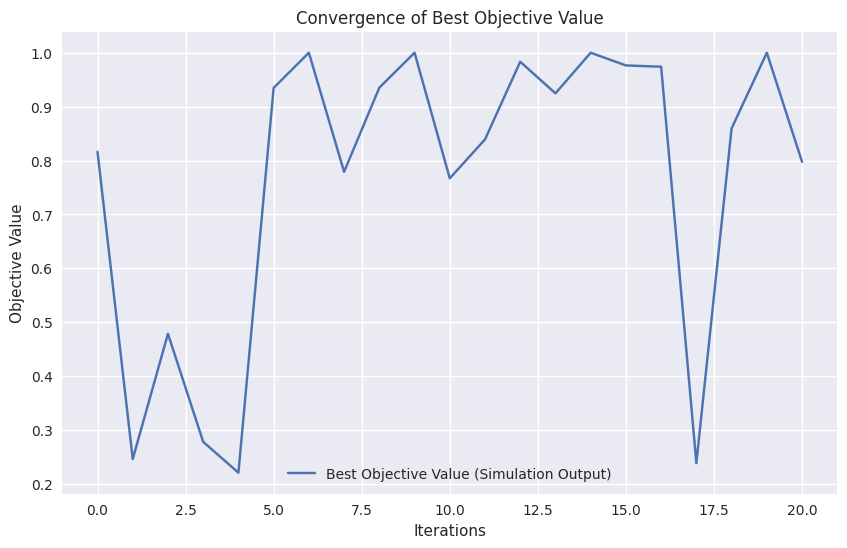

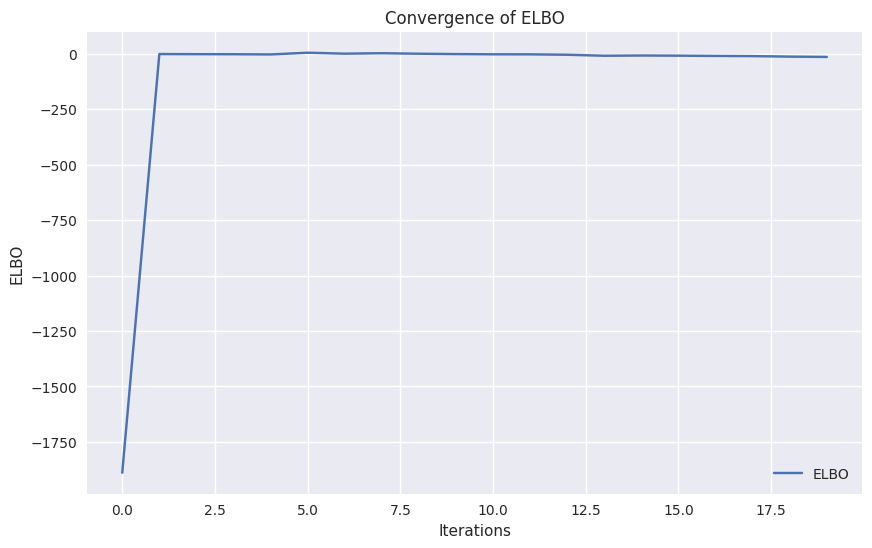

In [8]:
BEST_VALUE = jnp.max(Y)
BEST_PARAMS = X[jnp.argmax(Y)]
convergence_history = [BEST_VALUE]

elbo_history = []
var_history = []
length_history = []
noise_history = []

for iteration in range(NUM_ITERATIONS):
    print(f"\n Iteration {iteration}")

    # --- 1. Model Fitting via SVI ---
    rng_key, rng_key_ = random.split(rng_key)
    guide = AutoNormal(model)
    svi = SVI(model, guide, optim.Adam(LEARNING_RATE), Trace_ELBO(), X=jnp.array(X), Y=jnp.array(Y))
    svi_result = svi.run(rng_key_, 1000)
    params = svi_result.params

    elbo_history.append(svi_result.losses[-1])

    # --- 2. Draw Posterior Samples ---
    rng_key, rng_key_ = random.split(rng_key)
    samples = guide.sample_posterior(rng_key_, params, sample_shape=(1000,))
    
    # Extract kernel hyperparameters from the posterior samples.
    rng_key, rng_key_ = random.split(rng_key)
    keys = random.split(rng_key_, samples["kernel_var"].shape[0])
    vars = samples["kernel_var"]
    lengths = samples["kernel_length"]
    noises = samples["kernel_noise"]
    
    # --- 3. Generate Candidate Points ---
    rng_key, rng_key_ = random.split(rng_key)
    X_candidates = random.randint(rng_key_, (NUM_CANDIDATE_SAMPLES, 2), 0, 101)

    # --- 4. Evaluate Predictive Means over Candidate Points ---
    means, variances, _ = jax.vmap(
        lambda rng_key, var, length, noise: predict(
            rng_key, X, Y, jnp.array(X_candidates), var, length, noise, kernel=exponential_kernel)
    )(keys, vars, lengths, noises)

    # --- 5. Compute Expected Improvement (EI) ---
    f_best = jnp.max(Y)
    # ei = expected_improvement(means.mean(axis=0), variances.mean(axis=0), f_best)
    ei_samples = jax.vmap(lambda mu, sigma: expected_improvement(mu, sigma, f_best))(means, variances)
    ei = ei_samples.mean(axis=0)  # Average over posterior samples

    # --- 6. Select the Next Point to Evaluate ---
    best_idx = jnp.argmax(ei)
    next_candidate = np.array(X_candidates)[best_idx]

    # --- 7. Evaluate the Objective Function using the Simulation ---
    new_value = q3.simulate(next_candidate[0], next_candidate[1])
    
    print(f"Best observed value so far: {f_best}")
    print(f"Next candidate selected: {next_candidate}") # with EI: {ei[best_idx]}
    print(f"Simulation output at candidate: {new_value}")

    # --- 8. Update Training Data ---
    X = np.vstack([X, next_candidate])
    Y = np.append(Y, new_value)

    if new_value > BEST_VALUE:
        BEST_VALUE = new_value
        BEST_PARAMS = next_candidate

    convergence_history.append(new_value)
    var_history.append(jnp.mean(vars))
    length_history.append(jnp.mean(lengths))
    noise_history.append(jnp.mean(noises))

# Documenting the convergence behavior:
print("\n=== Convergence History (Best value over iterations) ===")
for i, val in enumerate(convergence_history):
    print(f"Iteration {i}: {val:.4f}")

# Plot the convergence of ELBO
plt.figure(figsize=(10, 6))
plt.plot(elbo_history, label="ELBO")
plt.xlabel("Iterations")
plt.ylabel("ELBO")
plt.title("Convergence of ELBO")
plt.grid(True)
plt.legend()
plt.show()

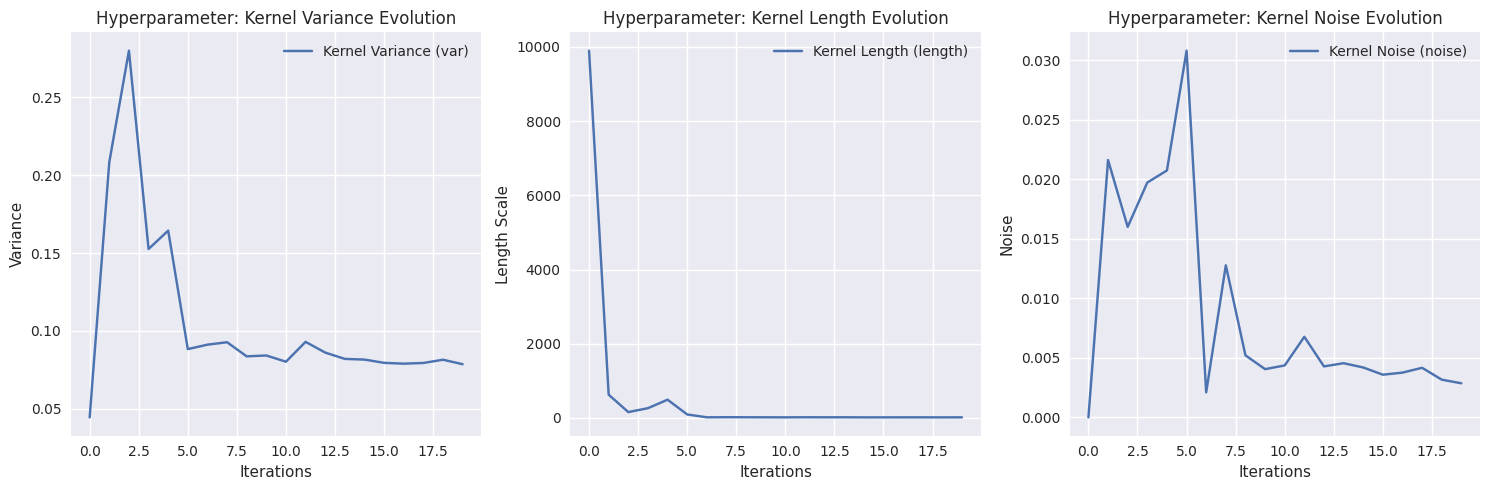

In [9]:
# --- Visualizing Hyperparameter Evolution ---
plt.figure(figsize=(15, 5))

# Plot kernel variance evolution
plt.subplot(1, 3, 1)
plt.plot(var_history, label="Kernel Variance (var)")
plt.xlabel("Iterations")
plt.ylabel("Variance")
plt.title("Hyperparameter: Kernel Variance Evolution")
plt.grid(True)
plt.legend()

# Plot kernel length scale evolution
plt.subplot(1, 3, 2)
plt.plot(length_history, label="Kernel Length (length)")
plt.xlabel("Iterations")
plt.ylabel("Length Scale")
plt.title("Hyperparameter: Kernel Length Evolution")
plt.grid(True)
plt.legend()

# Plot kernel noise evolution
plt.subplot(1, 3, 3)
plt.plot(noise_history, label="Kernel Noise (noise)")
plt.xlabel("Iterations")
plt.ylabel("Noise")
plt.title("Hyperparameter: Kernel Noise Evolution")
plt.grid(True)
plt.legend()

plt.tight_layout()
plt.show()

In [10]:
rng_key, rng_key_ = random.split(rng_key)
samples = guide.sample_posterior(rng_key_, params, sample_shape=(1000,))

# Extract kernel hyperparameters from the posterior samples.
rng_key, rng_key_ = random.split(rng_key)
keys = random.split(rng_key_, samples["kernel_var"].shape[0])
vars = samples["kernel_var"]
lengths = samples["kernel_length"]
noises = samples["kernel_noise"]

(400,)


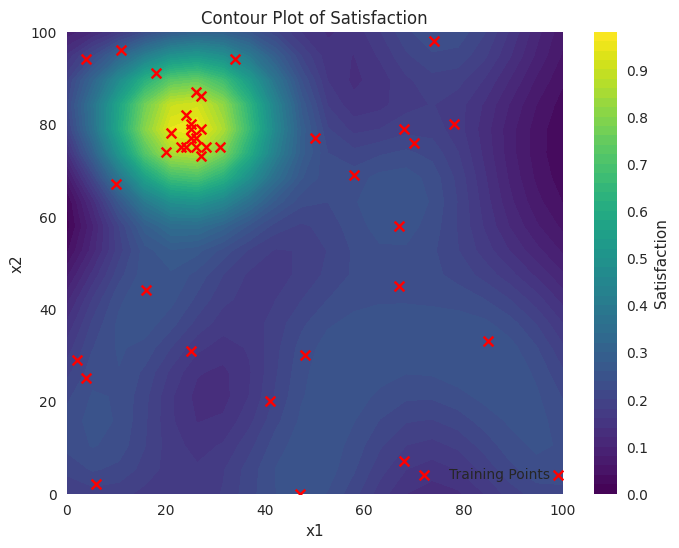

In [11]:


# Define grid resolution and domain bounds.
grid_size = 20  # number of points along each dimension
x1_vals = np.linspace(0, 100, grid_size)
x2_vals = np.linspace(0, 100, grid_size)
X1, X2 = np.meshgrid(x1_vals, x2_vals)

# Create candidate points in shape (grid_size*grid_size, 2)
X_grid = np.column_stack([X1.ravel(), X2.ravel()])
X_grid_jax = jnp.array(X_grid)

# Compute Expected Improvement for each candidate.
means, variances, _ = jax.vmap(
        lambda rng_key, var, length, noise: predict(
            rng_key, X, Y, jnp.array(X_grid_jax), var, length, noise, kernel=exponential_kernel)
    )(keys, vars, lengths, noises)

# ei_values = expected_improvement(means, variances, f_best=0)
ei_values = jnp.mean(means, axis=0)

print(ei_values.shape)
# Convert to NumPy array and reshape to grid.
EI_grid = np.array(ei_values).reshape((grid_size, grid_size))

# Plot the EI values as a contour plot.
plt.figure(figsize=(8, 6))
contour = plt.contourf(X1, X2, EI_grid, levels=50, cmap='viridis')
plt.colorbar(contour, label='Satisfaction')
plt.xlabel('x1')
plt.ylabel('x2')
plt.title('Contour Plot of Satisfaction')
# Overlay the training points for reference.
plt.scatter(X[:, 0], X[:, 1], c='red', marker='x', label='Training Points')
plt.legend()
plt.show()


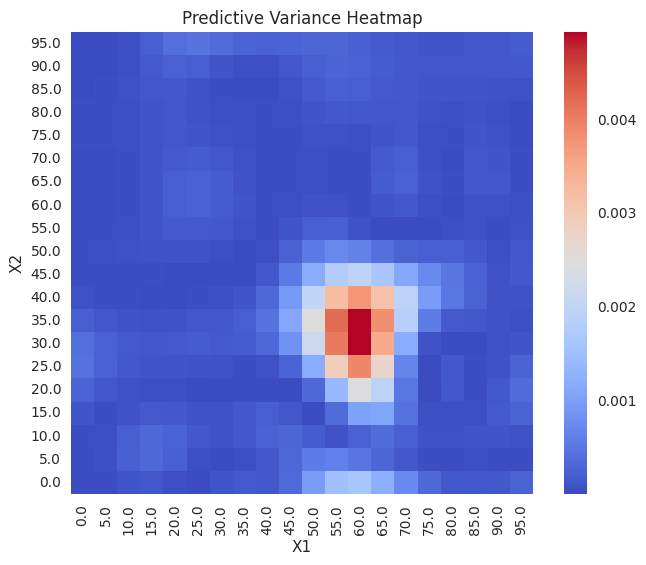

In [12]:
import seaborn as sns

plt.figure(figsize=(8, 6))

x_range = jnp.linspace(0, 100, 20, endpoint=False)
y_range = jnp.linspace(0, 100, 20, endpoint=False)
X_test_grid = jnp.array(jnp.meshgrid(x_range, y_range)).T.reshape(-1, 2)

means, sigma, _ = jax.vmap(lambda rng_key, var, length, noise: 
                           predict(rng_key, X, Y, X_test_grid, var, length, noise)
                           )(keys, vars, lengths, noises)

# Compute mean and variance across posterior samples
mean_pred = jnp.mean(means, axis=0).reshape(len(x_range), len(y_range))
var_pred = jnp.var(means, axis=0).reshape(len(x_range), len(y_range))

# Heatmap for Variance
sns.heatmap(var_pred[::-1], xticklabels=np.round(x_range, 2), yticklabels=np.round(y_range[::-1], 2),
            cmap="coolwarm", cbar=True, square=True)

plt.xlabel("X1")
plt.ylabel("X2")
plt.title("Predictive Variance Heatmap")
plt.show()

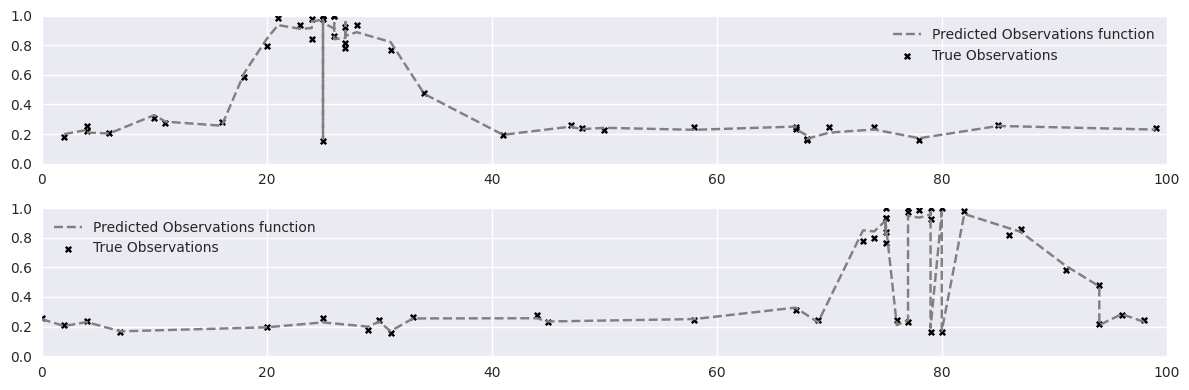

In [15]:
means, var, predictions = jax.vmap(
    lambda rng_key, var, length, noise: predict(rng_key, X, Y, jnp.array(X), var, length, noise, kernel=exponential_kernel)
)(keys, vars, lengths, noises)


mean_prediction = np.mean(means, axis=0)
percentiles = np.percentile(predictions, [5.0, 95.0], axis=0)

# Plot the result
fig, ax = plt.subplots(nrows=2, ncols=1, figsize=(12, 4))

X_sorted, Y_sorted, sorted_indices = sort_vectors(X, Y, axis=0)
ax[0].plot(X_sorted[:, 0], mean_prediction[sorted_indices], c="gray", ls="dashed", label="Predicted Observations function")
ax[0].scatter(X_sorted[:, 0], Y_sorted, s=15, c="k", marker="x", label="True Observations")
ax[0].set_xlim((0,100))
ax[0].set_ylim((0, 1))
ax[0].legend(loc="upper right")


X_sorted, Y_sorted, sorted_indices = sort_vectors(X, Y, axis=1)
ax[1].plot(X_sorted[:, 1], mean_prediction[sorted_indices], c="gray", ls="dashed", label="Predicted Observations function")
ax[1].scatter(X_sorted[:, 1], Y_sorted, s=15, c="k", marker="x", label="True Observations")
ax[1].set_xlim((0,100))
ax[1].set_ylim((0, 1))
ax[1].legend(loc="upper left")

plt.tight_layout()
plt.show()

Best Observed Parameters: [26 75]
Best Kernel Hyperparameters -> Variance: 0.07747828215360641, Length: 15.922334671020508, Noise: 0.004762239288538694


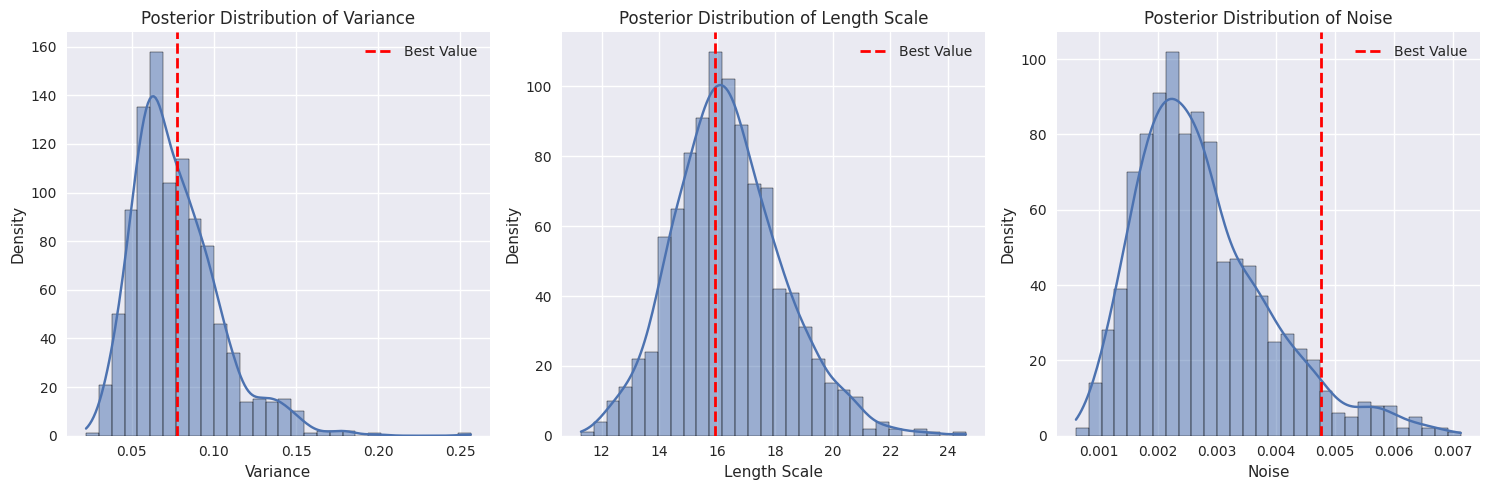

In [16]:
import seaborn as sns

# --- 1. Identify the best observed parameters ---
best_idx = jnp.argmax(Y)  # Index of best observed function value
best_params = X[best_idx]  # Corresponding input parameters

# --- 2. Find the closest posterior sample to best_params ---
# Compute distances between best_params and all samples
dists = jnp.linalg.norm(jnp.array(X_candidates) - best_params, axis=1)

# Get the index of the closest posterior sample
best_posterior_idx = jnp.argmin(dists)

# Retrieve the corresponding hyperparameters from posterior samples
best_var = vars[best_posterior_idx]
best_length = lengths[best_posterior_idx]
best_noise = noises[best_posterior_idx]

print(f"Best Observed Parameters: {best_params}")
print(f"Best Kernel Hyperparameters -> Variance: {best_var}, Length: {best_length}, Noise: {best_noise}")


# --- 1. Plot Kernel Hyperparameter Distributions ---
fig, axes = plt.subplots(1, 3, figsize=(15, 5))

# Variance Distribution
sns.histplot(vars, kde=True, bins=30, ax=axes[0])
axes[0].axvline(best_var, color='red', linestyle='dashed', linewidth=2, label="Best Value")
axes[0].set_title("Posterior Distribution of Variance")
axes[0].set_xlabel("Variance")
axes[0].set_ylabel("Density")
axes[0].legend()

# Length Scale Distribution
sns.histplot(lengths, kde=True, bins=30, ax=axes[1])
axes[1].axvline(best_length, color='red', linestyle='dashed', linewidth=2, label="Best Value")
axes[1].set_title("Posterior Distribution of Length Scale")
axes[1].set_xlabel("Length Scale")
axes[1].set_ylabel("Density")
axes[1].legend()

# Noise Distribution
sns.histplot(noises, kde=True, bins=30, ax=axes[2])
axes[2].axvline(best_noise, color='red', linestyle='dashed', linewidth=2, label="Best Value")
axes[2].set_title("Posterior Distribution of Noise")
axes[2].set_xlabel("Noise")
axes[2].set_ylabel("Density")
axes[2].legend()

plt.tight_layout()
plt.show()